# Логистическая регрессия
> Создание классификатора и оценка метриками качества

## Препроцессинг

In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('./heart.csv')
raw_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
# Все заголовки
print( '\n'.join( raw_data.columns.to_list() ) )

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


In [4]:
# Уникальные нечисловые значения
# Returns:
#     {column_name : {param : id, ...} | None , ... }
def get_uniq_non_numerical_values(df : pd.DataFrame) -> dict:
    unique_values = {}
    for colname in df.columns.to_list():
        # Проверяем тип
        if df[colname].dtype in ['int64', 'float']:
            unique_values[colname] = None #(False, [])
        else: 
            # Заносим в словарь
            d = {}
            # Генерируем маску на основе уникальных значений столбца
            for id_, param in enumerate(df[colname].unique().tolist()):
                d[param] = id_
            unique_values[colname] = d
            # Выводим только уникальные значения
            print(f"{colname}: {df[colname].unique().tolist()}")
    return unique_values

unique_colnames = get_uniq_non_numerical_values(raw_data)
print(50*'=')
# Там где значение уже числовое, вместо маски None
unique_colnames

Sex: ['M', 'F']
ChestPainType: ['ATA', 'NAP', 'ASY', 'TA']
RestingECG: ['Normal', 'ST', 'LVH']
ExerciseAngina: ['N', 'Y']
ST_Slope: ['Up', 'Flat', 'Down']


{'Age': None,
 'Sex': {'M': 0, 'F': 1},
 'ChestPainType': {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3},
 'RestingBP': None,
 'Cholesterol': None,
 'FastingBS': None,
 'RestingECG': {'Normal': 0, 'ST': 1, 'LVH': 2},
 'MaxHR': None,
 'ExerciseAngina': {'N': 0, 'Y': 1},
 'Oldpeak': None,
 'ST_Slope': {'Up': 0, 'Flat': 1, 'Down': 2},
 'HeartDisease': None}

In [5]:
# Препроцессинг -- превращение в числовой массив на основе переданных масок
def preprocessing(df : pd.DataFrame, masks : dict[str, dict[str, int]]) -> pd.DataFrame:
    df_ = df.copy()

    for colname in masks:
        mask = masks[colname]
        if mask != None: df_[colname] = df[colname].map(mask)

    return df_

data = preprocessing(raw_data, unique_colnames)
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,0,140,289,0,0,172,0,0.0,0,0
1,49,1,1,160,180,0,0,156,0,1.0,1,1
2,37,0,0,130,283,0,1,98,0,0.0,0,0
3,48,1,2,138,214,0,0,108,1,1.5,1,1
4,54,0,1,150,195,0,0,122,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,3,110,264,0,0,132,0,1.2,1,1
914,68,0,2,144,193,1,0,141,0,3.4,1,1
915,57,0,2,130,131,0,0,115,1,1.2,1,1
916,57,1,0,130,236,0,2,174,0,0.0,1,1


### А нужна ли стандартизация?
> Насколько я понял, ни шкалирование ни нормирование не обязательно, градиентный спуск всё равно подберёт коэффициенты.
> Но стандартизация может ускорить спуск.
>
> Кроме того, для метода k ближайших соседей стандартизация нужна


In [6]:
# # Шкалирование
# from math import sqrt
# def scale_list(series : list) -> pd.Series:
#     n = len(series)
#     mu = sum(series) / n
#     s = sqrt( sum( (d - mu)**2 for d in series ) / (n-1))
#     #print(f"n = {n} ; mu = {mu} ; s = {s}")
#     return (series - mu) / s

# def scale_df(df : pd.DataFrame, cols_for_scale : list[str]) -> pd.DataFrame:
#     scaled_df = df.copy()
#     for col in cols_for_scale:
#         scaled_df[col] = scale_list(df[col])
#     return scaled_df
from math import sqrt

def standatize_df(df:pd.DataFrame, cols_for_standart:list):
    df_ = df.copy()
    for colname in cols_for_standart:
        df_[colname] = df_[colname].astype(float)
        l = df_[colname].tolist()
        # Мат ожидание
        mean = sum(l) / len(l)
        # Стандартное отклонение
        std = sqrt( sum((x - mean) ** 2 for x in l) / len(l) )
        # Избегаем деления на 0
        std = std if std != 0 else 1;
        for i, _ in enumerate(l):
            df_.loc[i, colname] = (l[i] - mean) / std
    return df_

# Категориальные признаки можно не трогать
cols_for_standart = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
data = standatize_df(data, cols_for_standart)
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,0,0,0.410909,0.825070,0,0,1.382928,0,-0.832432,0,0
1,-0.478484,1,1,1.491752,-0.171961,0,0,0.754157,0,0.105664,1,1
2,-1.751359,0,0,-0.129513,0.770188,0,1,-1.525138,0,-0.832432,0,0
3,-0.584556,1,2,0.302825,0.139040,0,0,-1.132156,1,0.574711,1,1
4,0.051881,0,1,0.951331,-0.034755,0,0,-0.581981,0,-0.832432,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,0,3,-1.210356,0.596393,0,0,-0.188999,0,0.293283,1,1
914,1.536902,0,2,0.627078,-0.053049,1,0,0.164684,0,2.357094,1,1
915,0.370100,0,2,-0.129513,-0.620168,0,0,-0.857069,1,0.293283,1,1
916,0.370100,1,0,-0.129513,0.340275,0,2,1.461525,0,-0.832432,1,1


## Разделение выборки
> обучающая : тестовая == 70 : 30

In [7]:
import numpy as np
np.random.seed(42)

learning_part = 0.7
testing_part = 1 - learning_part
TARGET = 'HeartDisease'

zeros_data = data[data[TARGET] == 0]
ones_data  = data[data[TARGET] == 1]

def split_df(df : pd.DataFrame, first_part : int, second_part : int) -> (pd.DataFrame, pd.DataFrame):
    df_1 = df.head(int(len(df) * first_part))
    df_2 = df.tail(int(len(df) * second_part))
    return (df_1, df_2)

learning_zeros_data, testing_zeros_data = split_df(zeros_data, learning_part, testing_part)
learning_ones_data, testing_ones_data   = split_df(ones_data, learning_part, testing_part)

learning_data = pd.concat([ learning_zeros_data, learning_ones_data ])
#np.random.shuffle(learning_data)
learning_data.sample(frac=1)

testing_data  = pd.concat([ testing_zeros_data,  testing_ones_data  ])
#np.random.shuffle(testing_data)
testing_data.sample(frac=1)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
826,-0.266338,0,1,-0.399724,0.422599,1,2,1.147139,0,1.418998,1,0
876,0.688318,0,2,-0.129513,0.065863,0,2,-0.188999,1,1.418998,1,1
674,0.900464,0,0,-0.669935,0.751894,0,2,-1.328647,0,0.480902,1,1
696,-1.963504,0,2,-0.669935,-0.007314,0,0,-0.267596,1,0.668521,1,1
631,-0.796702,0,2,0.410909,1.026306,0,0,-0.660578,1,0.856140,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
676,-0.266338,1,2,-0.129513,0.971423,0,0,0.203982,1,0.293283,1,1
910,-1.327067,0,0,-0.669935,-0.382344,0,0,1.775910,0,-0.832432,0,0
699,0.370100,0,2,-1.210356,0.020128,0,0,-0.424789,1,0.574711,1,0
661,-0.478484,0,1,-0.778019,-0.455520,0,2,-0.424789,0,-0.081956,0,1


In [8]:
len(zeros_data)

410

In [9]:
len(ones_data)

508

## Логистическая регрессия
> 1. Логистическая функция
>    $$\frac{1}{1+e^{-x}}$$
> 2. Модель
>    $$y_i=f(x_i\beta)+{\epsilon}_i $$
> 3. Фнукция правдоподобия (функция распределения)
>    $$p(y_i|x_i\beta)=f(x_i\beta)^{y_i}(1-f(x_i\beta))^{1-y_i}$$

> Потом мы логарифмируем функцию правдоподобия. Максимум этих функций совпадает.
>
> Это нужно потому что вместо произведения появляется сумма (легче дифференциировать), степень превращается в множитель

### Градиентный спуск

In [10]:
# Градиент
# f - функция
# theta - точка 
def gradient(f, theta : list, h = 1e-8) -> list:
    grad = []
    # Считаем частные производные для каждой координаты
    for i, _ in enumerate(theta):
        left_theta = theta.copy()
        left_theta[i] -= h
        
        right_theta = theta.copy()
        right_theta[i] += h
        grad.append( ( f(right_theta) - f(left_theta) ) / (2 * h) )
    return grad

from math import sqrt
def gradient_descent(f, init_theta, step=0.01, max_iters=1000, eps=1e-6) -> list:
    theta_ = init_theta.copy()
    prev_theta = f(theta_)
    
    for i in range(max_iters):
        # Градиент
        grad = gradient(f, theta_)

        # Значение функции для заданного шага
        #f_arbitrary_step = lambda alpha: f([ theta_[x] - alpha * grad[x] for x, _ in enumerate(theta_) ])
        # Линейная минимизация для поиска шага
        #step = gold_section_minimization(f_arbitrary_step, 0, 1)
        
        # Новое приближение
        new_theta_ = [ theta_[x] - step * grad[x] for x, _ in enumerate(theta_) ]
        # Критерий остановки
        if sqrt( sum( ( (new_theta_[x] - theta_[x])**2 for x, _ in enumerate(theta_) ) ) ) < eps: break

        prev = theta_
        theta_ = new_theta_

        # Меняем шаг
        if theta_ > prev: step *= 0.5
    if i == max_iters-1: print('WARNING: Достигнуто максимальное число итераций')
    return theta_

### Вычисление коэффициентов
> Стоит обратить внимание, что подразумевается что в списках матрицы X столько же элементов, сколько и коэффициентов в theta
> 
> То есть надо будет **транспанировать матрицу при вызове**

In [11]:
from math import exp
from math import log

# Приводит к интервалу (0:1)
def sigmoid(x : float) -> float:
    return 1.0 / (1 + exp(-x))

def dot(a:list, b:list) -> float: 
    return sum([aa*bb for aa,bb in zip(a,b)])

# Функция правдоподобия -- для максимизации
# likehood - подобие [учим английский)]
def log_likehood_i(x:list, y_i:float, theta:list) -> float:
    base = sigmoid(dot(x, theta))
    return log(base) if y_i == 1 else log(1-base)

def log_likehood(X:list[list], y:list, theta:list) -> float:
    return sum(log_likehood_i(x, y_i, theta) for x, y_i in zip(X, y))

def logistic_regression(X:list[list], y:list, init_theta:list, step=0.01, max_iters=1000, eps=1e-6) -> list:
    # Отрицательная функция правдоподобия - для минимизации 
    # (+ замыкание, запоминаем X и y в локальном окружении 
    # чтобы не таскать за собой)
    fn = lambda theta: -log_likehood(X, y, theta)
    
    # Используем градиентный спуск
    return gradient_descent(fn, init_theta)

In [12]:
# Делим выборку на X и y
data_x = [ data[column].tolist() for column in data.drop(columns=[TARGET]) ]
learning_data_x = [ learning_data[column].tolist() for column in learning_data.drop(columns=[TARGET]) ]
testing_data_x  = [ testing_data[column].tolist() for column in testing_data.drop(columns=[TARGET]) ]

data_y = data[TARGET].tolist()
learning_data_y = learning_data[TARGET].tolist()
testing_data_y  = testing_data[TARGET].tolist()

# def add_intrecept_col(M:list[list]):
#     M_ = M.copy()
#     M_.append([1] * len(M[0]))
#     return M

# Транспонируем X (причина описана в заголовке)
import numpy as np
T_data_x = np.array( data_x ).T.tolist()
T_testing_data_x = np.array( testing_data_x ).T.tolist()
T_learning_data_x = np.array( learning_data_x ).T.tolist()

# Начальное приближение
init_theta = [0 for _ in learning_data_x]

best_theta = logistic_regression(T_learning_data_x, learning_data_y, init_theta)

In [13]:
for i, name in enumerate(data.drop(columns=[TARGET])):
    print(f"{name}: {best_theta[i]}")

Age: 0.03911312177287164
Sex: -1.0476315461067571
ChestPainType: -0.04887923321433493
RestingBP: 0.06215886616512366
Cholesterol: -0.6195577495048815
FastingBS: 0.6998658016394224
RestingECG: -0.7249745762351583
MaxHR: -0.5077003816672272
ExerciseAngina: 0.5009888944819927
Oldpeak: 1.056335585793459
ST_Slope: 1.4689272590611127


### Функция предсказания

In [14]:
def prediction(X, theta):
    preds = []
    y_pred = []
    for x in X:
        predict = sigmoid(dot(x, theta))
        preds.append(predict)
        y_pred.append( 1 if predict >= 0.5 else 0 )
    #print(preds)
    return y_pred, preds

log_predicted, _ = prediction(T_testing_data_x, best_theta)
#np.array(predicted_y ) == np.array(testing_data_y)

### Отмечаем нестабильные предсказания

In [15]:
all_predicted_y, all_predicts = prediction(T_data_x, best_theta)

In [16]:
min_unstable_part = 0.2

def mark_unstable_predictions(df:pd.DataFrame, predict:list, eps=1e-2) -> (pd.DataFrame, int):
    df_ = df.copy()
    count = 0
    for i, _ in enumerate(df_[TARGET]):
        if abs(predict[i] - 0.5) < eps: 
            df_.loc[i, TARGET] = -1
            count+=1
    return df_, count

def mark_more_unstable_predictions(df:pd.DataFrame, predict:list, min_part=0.2) -> (pd.DataFrame, int):
    df_ = df.copy()
    min_marked_count = int(len(df) * min_part) + 1
    marked_count = 0
    eps = 1e-4
    while marked_count < min_marked_count:
        df_, inc = mark_unstable_predictions(df, predict, eps)
        marked_count += inc
        eps *= 2
    return df_, marked_count

marked_data, amount_of_marks = mark_more_unstable_predictions(data, all_predicts, min_unstable_part)
print(f"Помечено нестабильными: {amount_of_marks} / {len(data)} ({amount_of_marks/len(data):.1%})")

Помечено нестабильными: 191 / 918 (20.8%)


# Метод $k$ ближайших соседей
> Определяем k ближайших точек из выборки для обучения,
> и на основе метки большинства устанавливаем метку для этой точки

In [17]:
import numpy as np
from math import sqrt

# Расстояние между векторами (евклидово)
def distance(a:list, b:list):
    na = np.array(a)
    nb = np.array(b)
    return sqrt( sum( (na-nb)**2 ) )

In [18]:
from collections import Counter

# Классификация методом k ближайших соседей
# X -- список обучающих векторов
# Замыкание чтобы не передавать обучающую выборку каждый раз
def create_knn_classify(default_k:int, X:list[list], y:list):
    Data = [ x + [y_i] for x,y_i in zip(X, y) ] 
    # Выбор самой важной точки
    def democracy(nearest_points):
        # Получаем словарь уникальных значений : количество повторений
        vote_counts = Counter(nearest_points)
        # Самый частый элемент (список из одного)
        candidate, candidate_count = vote_counts.most_common(1)[0]
        # Ищем элементы которые встречаются так же часто
        candidates = []
        for point in vote_counts: 
            if vote_counts[point] == candidate_count: 
                candidates.append(point)
        # Если кандидат не один, убираем дальнюю точку и считаем снова
        if len(candidates) != 1: return democracy(nearest_points[:-1])
        return candidate
    # Сама функция  
    def knn_classify(new_point:list, k:int = default_k):
        # Сортируем точки по расстоянию
        # point - это точка с меткой (data), а new_point - только точка (x)
        points_by_distance = sorted(Data, key = lambda point: distance(point[:-1], new_point) )
        # Выбираем k ближайших (только метки)
        k_nearest = [ point[-1] for point in points_by_distance[:k] ]
        # Голосование (возвращает точку, берём только метку как результат)
        return democracy(k_nearest)
    
    return knn_classify

In [19]:
# Для метрик
def get_statistic_for_metrics(predicted_y, testing_y):
    true_positive, true_negative = 0, 0
    false_positive, false_negative = 0, 0
    
    for y_pred, y_true in zip(predicted_y, testing_data_y):
        if y_pred == y_true == 1: true_positive += 1
        elif y_pred == y_true == 0: true_negative += 1
        elif y_pred != y_true and y_pred == 0: false_negative += 1
        elif y_pred != y_true and y_pred == 1: false_positive += 1
    return true_positive, true_negative, false_positive, false_negative


In [20]:
#knn_classify = create_knn_classify(3, T_learning_data_x, learning_data_y)

def knn_prediction(X):
    y = []
    for x in X:
        y.append(knn_classify(x))
    return y

best = 0
best_k = -1
for k in range(1, 10):
    knn_classify = create_knn_classify(k, T_learning_data_x, learning_data_y)
    knn_predicted = knn_prediction(T_testing_data_x)
    log_TP, log_TN, log_FP, log_FN = get_statistic_for_metrics(log_predicted, testing_data_y)
    log_precision = log_TP / (log_TP + log_FP)
    if log_precision > best: 
        best = log_precision
        best_k = k


knn_classify = create_knn_classify(best_k, T_learning_data_x, learning_data_y)


knn_predicted = knn_prediction(T_testing_data_x)

In [31]:
print(f"Выбрано оптимальное количество соседей из диапазона [1-10): k = {best_k}")

Выбрано оптимальное количество соседей из диапазона [1-10): k = 1


# Оценка метриками
> Precision, Recall, F1, Accuracy

> Для нашего примера Positive метка это 1, Negative это 0
> 
> **TP**, **TN** (*True Positive/Negative*) -- верно предсказанные метки
> 
> **FP** (*False Positive*) -- предсказана метка 1, на самом деле 0
>
> **FN** (*False Negative*) -- предсказана метка 0, на самом деле 1


> **Precision** -- точность при определении Positive (сколько из найденных Positive действительно таковы)
> $$Precision = \frac{TP}{TP+FP}$$
>
> **Recall** -- учитывает неверно предсказанные Negative (когда не распознали Positive)
> $$Recall = \frac{TP}{TP+FN}$$
> 
> **F1** -- среднее (гармоническое) между Precision и Recall
> $$F_1 = 2 \frac{Precision\cdot Recall}{Precision+Recall}$$
> 
> **Accuracy** -- сколько значений предсказанно верно; может быть обманчива, потому что не учитывает разницу между предсказаниями positive и negative
> $$Accuracy = \frac{TP + TN}{TP+TN+FP+FN}$$

### Логистическая классификация

In [21]:
log_TP, log_TN, log_FP, log_FN = get_statistic_for_metrics(log_predicted, testing_data_y)

print(log_TP, log_TN)
print(log_FP, log_FN)

99 96
27 53


In [22]:
import matplotlib.pyplot as plt

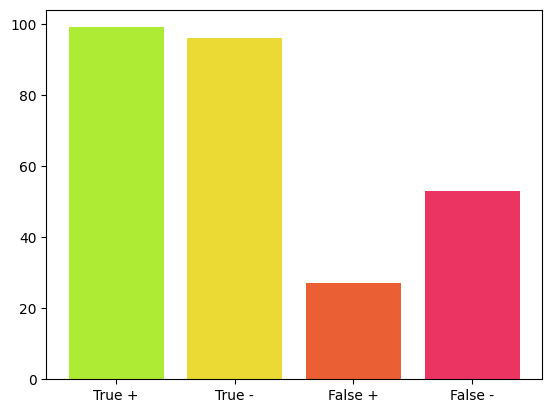

In [23]:
values = [log_TP, log_TN, log_FP, log_FN]
colors = ['#aeeb34', '#ebd934', '#eb5f34', '#eb3462']
labels = ['True +', 'True -', 'False +', 'False -']

plt.bar(labels, values, color=colors)

plt.show()

In [24]:
log_precision = log_TP / (log_TP + log_FP)
log_recall    = log_TP / (log_TP + log_FN)
log_F1 = 2 * (log_precision * log_recall) / (log_precision + log_recall)

In [25]:
print(f"Precision: {log_precision}")
print(f"Recall: {log_recall}")
print(f"F1: {log_F1}")

Precision: 0.7857142857142857
Recall: 0.6513157894736842
F1: 0.7122302158273381


### Классификация методом ближайших соседей

In [26]:
knn_TP, knn_TN, knn_FP, knn_FN = get_statistic_for_metrics(knn_predicted, testing_data_y)
print(knn_TP, knn_TN)
print(knn_FP, knn_FN)

85 102
21 67


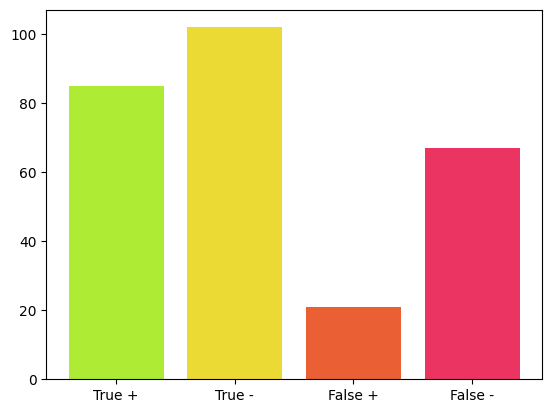

In [27]:
values = [knn_TP, knn_TN, knn_FP, knn_FN]
colors = ['#aeeb34', '#ebd934', '#eb5f34', '#eb3462']
labels = ['True +', 'True -', 'False +', 'False -']

plt.bar(labels, values, color=colors)

plt.show()

In [28]:
knn_precision = knn_TP / (knn_TP + knn_FP)
knn_recall    = knn_TP / (knn_TP + knn_FN)
knn_F1 = 2 * (knn_precision * knn_recall) / (knn_precision + knn_recall)
knn_accuracy = (knn_TP + knn_TN) / len(knn_predicted)

In [29]:
print(f"Precision: {knn_precision}")
print(f"Recall: {knn_recall}")
print(f"F1: {knn_F1}")
print(f"Accuracy: {knn_accuracy}")

Precision: 0.8018867924528302
Recall: 0.5592105263157895
F1: 0.6589147286821705
Accuracy: 0.68


# Выводы
> Метрики Precision, Recall, F1, немного выше для метода БС -- он справляется с предсказанием немного лучше.
>
> Высокий Precision показывает, что модели редко ошибаются в предсказании Positive, но чуть меньший Recall показывает, что не все Positive распознаются. Если переносить эту оценку на датасет, можно сказать что обе модели редко ошибаются если заболевание предсказано, но иногда могут не распознать заболевание.
>
> В целом обе модели показывают хорошие метрики и справляются с классификацией